In [ ]:
# In this notebook, we run inference and evaluation for each of the models on each of the other validation data sets, to assess the generalisation ability of each interface representation

In [5]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np

from src.interface_representation.interface_types import InterfaceType


In [2]:
# First, assemble the 4 datasets which we want to use for evaluation
# We want the paths to the dataset, exluding the final dir which specifies the interface type

mu_sphere_1_base = Path('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_1.00')

mu_sphere_2_base = Path('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_2.00')

mu_sphere_25_base = Path('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/mu_spheres/spheres_mu_2.50')

hit_base = Path('/Users/murray/Projects/multphase_flow_encoder/multiphase_flow_encoder/src/preprocessing/data/patched_hit_experiment')

dataset_name_to_base = {
    'spheres_mu_100': mu_sphere_1_base,
    'spheres_mu_200': mu_sphere_2_base,
    'spheres_mu_250': mu_sphere_25_base,
    'hit': hit_base
}

dataset_interface_types = [
    'TANH_EPSILON0.0078125',
    'TANH_EPSILON0.015625',
    'TANH_EPSILON0.03125',
    'TANH_EPSILON0.0625',
    'TANH_EPSILON0.125',
    'TANH_EPSILON0.25',
    'HEAVISIDE',
    'SIGNED_DISTANCE_EXACT',
]

dataset_interface_types_to_interface_type = {
    'TANH_EPSILON0.0078125': InterfaceType.TANH_EPSILON,
    'TANH_EPSILON0.015625': InterfaceType.TANH_EPSILON,
    'TANH_EPSILON0.03125': InterfaceType.TANH_EPSILON,
    'TANH_EPSILON0.0625': InterfaceType.TANH_EPSILON,
    'TANH_EPSILON0.125': InterfaceType.TANH_EPSILON,
    'TANH_EPSILON0.25': InterfaceType.TANH_EPSILON,
    'HEAVISIDE': InterfaceType.HEAVISIDE,
    'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
}

dataset_interface_types_to_epsilon = {
    'TANH_EPSILON0.0078125': 0.0078125,
    'TANH_EPSILON0.015625': 0.015625,
    'TANH_EPSILON0.03125': 0.03125,
    'TANH_EPSILON0.0625': 0.0625,
    'TANH_EPSILON0.125': 0.125,
    'TANH_EPSILON0.25': 0.25,
    'HEAVISIDE': None,
    'SIGNED_DISTANCE_EXACT': None,
}

# Check all datasets are present, make sure directory exists

datasets = []

@dataclass
class Dataset():
    name: str
    interface_type: InterfaceType
    epsilon: float
    path: Path

for dataset_name, base in dataset_name_to_base.items():
    for interface_type in dataset_interface_types:
        path = base / interface_type
        assert path.exists(), f'{path} does not exist'
        
        it = dataset_interface_types_to_interface_type[interface_type]
        epsilon = dataset_interface_types_to_epsilon[interface_type]
        
        datasets.append(Dataset(dataset_name, it, epsilon, path))
        
# Given interface type and epsilon, map to a dict of dataset name to dataset path


def get_datasets_given_interface(interface_type, epsilon, datasets):
    matching_datasets = [d for d in datasets if d.interface_type == interface_type and d.epsilon == epsilon]
    return matching_datasets



In [3]:
# Next, assemble the paths to the models which we want to evaluate (these are v24 and v25)

base_output_dir = Path('./../../output/lassen')
files_v25 = list(base_output_dir.glob('interfacial_ae_v25_*'))
files_v24 = list(base_output_dir.glob('interfacial_ae_v24_*'))

print(len(files_v25))
print(len(files_v24))

# For each one, we want to associate with:
# - The interface type
# - The dataset name

@dataclass
class TrainedModel():
    interface_type: InterfaceType
    epsilon: float
    dataset_name: str
    model_path: Path
    
trained_models = []

def extract_interface_type_v25(outdir):

    final_part = '_'.join(outdir.stem.split('_')[8:-1])

    final_part = final_part.replace('datadir', '')

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
    }

    return str_to_type[final_part]

def extract_epsilon_v25(outdir):
    final_part = '_'.join(outdir.stem.split('_')[8:-1])
    final_part = final_part.replace('datadir', '')
    
    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
    }
    
    return str_to_epsilon[final_part]

def extract_dataset_name_v25(outdir):
    part = '_'.join(outdir.stem.split('_')[5:8])
    part = part.replace('datadir', '')
    return part

def extract_model_path_v25(outdir):
    model_path = outdir / 'model-100.pt'
    assert model_path.exists()
    return model_path

def extract_interface_type_v24(outdir):

    final_part = '_'.join(outdir.stem.split('_')[5:-1])
    
    final_part = final_part.replace('datadir', '')

    str_to_type = {
        'TANH_EPSILON00078125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0015625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON003125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON00625': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON0125': InterfaceType.TANH_EPSILON,
        'TANH_EPSILON025': InterfaceType.TANH_EPSILON,
        'HEAVISIDE': InterfaceType.HEAVISIDE,
        'SIGNED_DISTANCE_EXACT': InterfaceType.SIGNED_DISTANCE_EXACT,
    }

    return str_to_type[final_part]

def extract_epsilon_v24(outdir):
    final_part = '_'.join(outdir.stem.split('_')[5:-1])
    final_part = final_part.replace('datadir', '')
    
    str_to_epsilon = {
        'TANH_EPSILON00078125': 0.0078125,
        'TANH_EPSILON0015625': 0.015625,
        'TANH_EPSILON003125': 0.03125,
        'TANH_EPSILON00625': 0.0625,
        'TANH_EPSILON0125': 0.125,
        'TANH_EPSILON025': 0.25,
        'HEAVISIDE': None,
        'SIGNED_DISTANCE_EXACT': None,
    }
    
    return str_to_epsilon[final_part]

def extract_dataset_name_v24(outdir):
    return 'hit'

def extract_model_path_v24(outdir):
    model_path = outdir / 'model-15.pt'
    assert model_path.exists()
    return model_path


for f in files_v24:
    interface_type = extract_interface_type_v24(f)
    dataset_name = extract_dataset_name_v24(f)
    model_path = extract_model_path_v24(f)
    epsilon = extract_epsilon_v24(f)
    
    trained_models.append(TrainedModel(interface_type, epsilon, dataset_name, model_path))
    
for f in files_v25:
    interface_type = extract_interface_type_v25(f)
    dataset_name = extract_dataset_name_v25(f)
    model_path = extract_model_path_v25(f)
    epsilon = extract_epsilon_v25(f)
    
    trained_models.append(TrainedModel(interface_type, epsilon, dataset_name, model_path))
    
print(len(trained_models))


24
0
24


In [ ]:
# Iterate over every model / dataset combination
# For each combination, run inference on the dataset, recording predictions and gt in dedicated results dir

from src.eval_utils import load_dataset, load_model, run_inference
import numpy as np
from tqdm import tqdm

for tm in tqdm(trained_models, desc='Evaluating all trained models'):
    
    matching_datasets = get_datasets_given_interface(tm.interface_type, tm.epsilon, datasets)
    
    assert len(matching_datasets) == 4
    
    for dataset_info in matching_datasets:
        print(f'Interface: {tm.interface_type}, {tm.epsilon}. Model trained on {tm.dataset_name}, evaluating on {dataset_info.name}')
        
        model = load_model(tm.model_path)
        
        if tm.dataset_name == 'hit':
            dataset = load_dataset(dataset_info.path, max_num_samples=25_000)
        else:
            dataset = load_dataset(dataset_info.path)
            
        gts, preds = run_inference(dataset, model, N=50)
        
        outname = f'{tm.interface_type}_{tm.epsilon}_{tm.dataset_name}_{dataset_info.name}.npz'
        outdir = Path('ood_results')
        np.savez_compressed(outdir / outname, gts=gts, preds=preds, epsilon=tm.epsilon, interface_type=tm.interface_type, train_dataset_name=tm.dataset_name, eval_dataset_name=dataset_info.name)
        
        
    
    
    

In [6]:

# Now, let's compute dice scores for all these results
# Construct a large pandas DataFrame where we store: interface label (type + epsilon), train dataset, eval dataset, mean dice score

from src.eval_utils import get_phi_sharp, dice_coefficient
from fractions import Fraction
import pandas as pd
import matplotlib.pyplot as plt

result_rows = []


def float_to_fraction(float_num):
    fraction = Fraction(float(float_num)).limit_denominator()
    return f"{fraction.numerator}/{fraction.denominator}"


def get_interface_label(interface_type, epsilon):
    if interface_type == InterfaceType.TANH_EPSILON:
        return f'Tanh {float_to_fraction(epsilon)}'
    elif interface_type == InterfaceType.HEAVISIDE:
        return 'Sharp'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_EXACT:
        return 'SDF'
    elif interface_type == InterfaceType.SIGNED_DISTANCE_APPROXIMATE:
        return 'SDF approx'
    else:
        raise ValueError('Unknown interface type')
    
    
def adjust_dataset_labels(dataset_name):
    if dataset_name == 'spheres_mu_100':
        return 'Spheres ($\\mu=1.0$)'
    elif dataset_name == 'spheres_mu_200':
        return 'Spheres ($\\mu=2.0$)'
    elif dataset_name == 'spheres_mu_250':
        return 'Spheres ($\\mu=2.5$)'
    elif dataset_name == 'hit':
        return 'Droplet in HIT'
    else:
        raise ValueError('Unknown dataset name')
    

for inference_result in Path('ood_results').glob('*.npz'):
    data = np.load(inference_result, allow_pickle=True)
    gts = data['gts']
    preds = data['preds']
    interface_type = data['interface_type']
    
    dice_scores = []
    
    for gt, pred in zip(gts, preds):
        gt_sharp = get_phi_sharp(gt, interface_type)
        pred_sharp = get_phi_sharp(pred, interface_type)
        
        dice = dice_coefficient(gt_sharp, pred_sharp)
        dice_scores.append(dice)
        
    mean_dice = np.nanmean(dice_scores)
    
    result_rows.append({
        'interface_label': get_interface_label(interface_type, data['epsilon']),
        'train_dataset': adjust_dataset_labels(data['train_dataset_name']),
        'eval_dataset': adjust_dataset_labels(data['eval_dataset_name']),
        'mean_dice': mean_dice
    })
    
df = pd.DataFrame(result_rows)

# Now, for each interface_label, show a heatmap for train_dataset vs eval_dataset

interface_labels = df['interface_label'].unique()

# Sort interface labels
def sort_key(interface_label):
    if interface_label == 'Sharp':
        return 0
    elif interface_label == 'SDF':
        return 100
    else:
        # Extract and sort by epsilon
        return float(interface_label.split(' ')[1].split('/')[0]) / float(interface_label.split(' ')[1].split('/')[1])
    
interface_labels = sorted(interface_labels, key=sort_key)
    
print(interface_labels)

subdfs = []

for interface_label in interface_labels:
    subdf = df[df['interface_label'] == interface_label]
    subdf = subdf.drop(columns='interface_label')
    subdf = subdf.pivot(index='train_dataset', columns='eval_dataset', values='mean_dice')
    
    subdfs.append((interface_label, subdf))
    

['Sharp', 'Tanh 1/128', 'Tanh 1/64', 'Tanh 1/32', 'Tanh 1/16', 'Tanh 1/8', 'Tanh 1/4', 'SDF']


In [7]:
df[df['interface_label'] == 'SDF']

,interface_label,train_dataset,eval_dataset,mean_dice
6,SDF,Spheres ($\mu=1.0$),Spheres ($\mu=2.0$),0.000000
23,SDF,Spheres ($\mu=2.0$),Droplet in HIT,0.728294
31,SDF,Spheres ($\mu=1.0$),Spheres ($\mu=1.0$),0.000000
43,SDF,Spheres ($\mu=2.0$),Spheres ($\mu=2.5$),0.974863
58,SDF,Droplet in HIT,Spheres ($\mu=2.5$),0.913820
59,SDF,Spheres ($\mu=2.5$),Spheres ($\mu=2.5$),0.888806
79,SDF,Droplet in HIT,Spheres ($\mu=1.0$),0.609049
80,SDF,Spheres ($\mu=2.5$),Spheres ($\mu=1.0$),0.524922
87,SDF,Spheres ($\mu=1.0$),Spheres ($\mu=2.5$),0.000000
94,SDF,Droplet in HIT,Droplet in HIT,0.915683


In [8]:
df.to_csv("ood_results.csv")

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_4390/3067747517.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


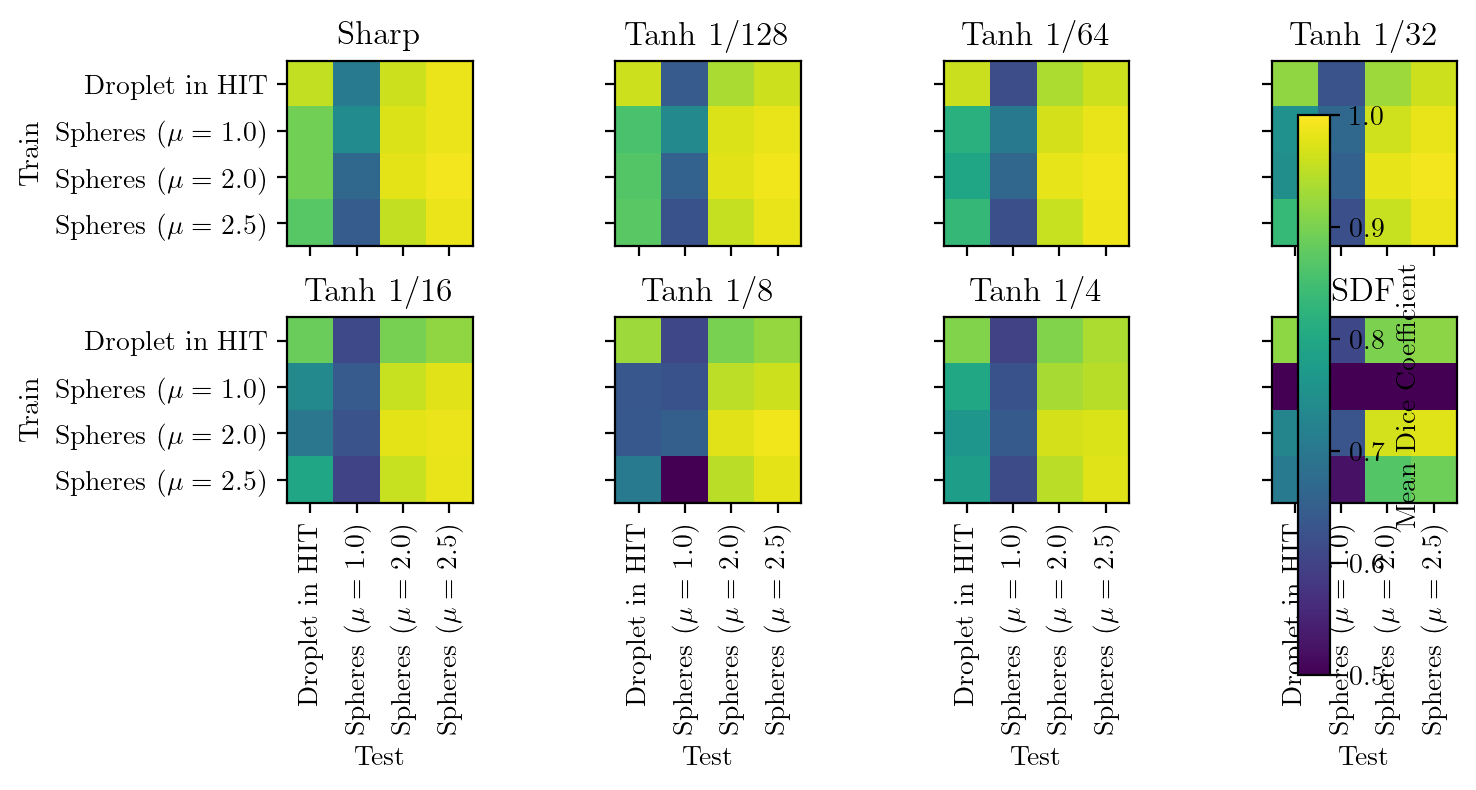

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4), dpi=200, sharex=True, sharey=True)

for i, (interface_label, subdf) in enumerate(subdfs):
    ax = axs[i // 4, i % 4]
    ax.set_title(interface_label)
    im = ax.imshow(subdf, cmap='viridis', vmin=0.5, vmax=1)
    ax.set_xticks(range(len(subdf.columns)))
    ax.set_yticks(range(len(subdf.index)))
    ax.set_xticklabels(subdf.columns, rotation=90)
    ax.set_yticklabels(subdf.index)
    
axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Train')
axs[1, 0].set_xlabel('Test')
axs[1, 1].set_xlabel('Test')
axs[1, 2].set_xlabel('Test')
axs[1, 3].set_xlabel('Test')
    
# Create colorbar on RHS
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Mean Dice Coefficient')
    
plt.tight_layout()
plt.savefig('ood_results.pdf')
plt.show()

/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_4390/1902560268.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.87, 1])  # <-- exclude colorbar


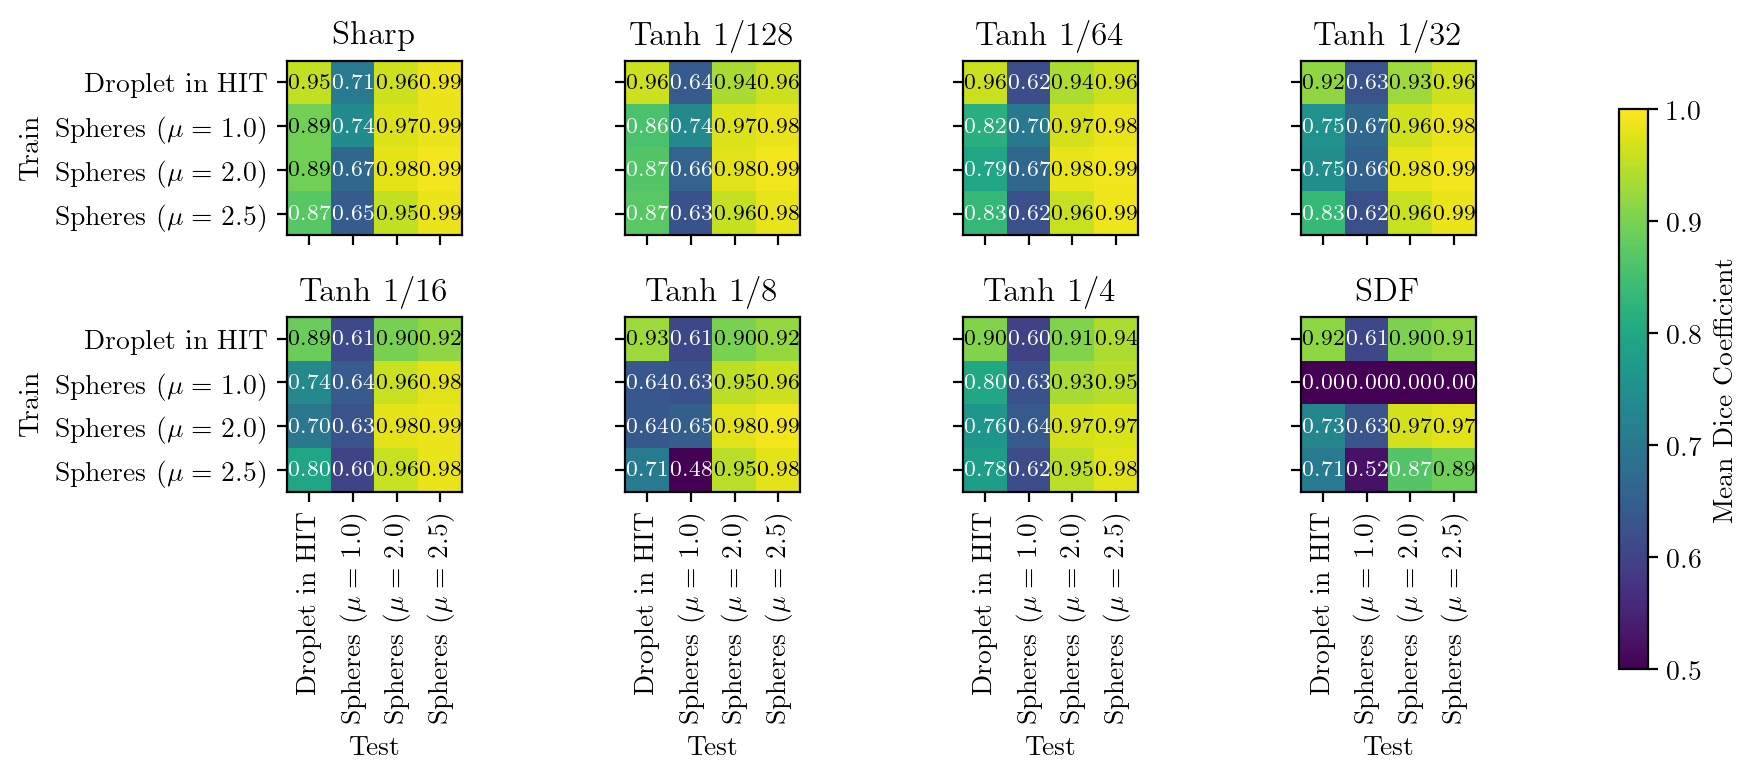

In [11]:

fig, axs = plt.subplots(2, 4, figsize=(9.5, 4), dpi=200, sharex=True, sharey=True)  # wider
# Or: fig, axs = plt.subplots(2, 4, figsize=(8, 4), dpi=200, sharex=True, sharey=True, constrained_layout=True)

for i, (interface_label, subdf) in enumerate(subdfs):
    ax = axs[i // 4, i % 4]
    ax.set_title(interface_label)
    im = ax.imshow(subdf, cmap='viridis', vmin=0.5, vmax=1)
    ax.set_xticks(range(len(subdf.columns)))
    ax.set_yticks(range(len(subdf.index)))
    ax.set_xticklabels(subdf.columns, rotation=90)
    ax.set_yticklabels(subdf.index)
    # Annotate heatmap with values
    for (row, col), val in np.ndenumerate(subdf.values):
        # Choose text color for good contrast
        color = "white" if im.norm(val) < 0.75 else "black"
        ax.text(col, row, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8, fontweight='bold')

axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Train')
for j in range(4):
    axs[1, j].set_xlabel('Test')

plt.subplots_adjust(right=0.87)  # <-- make space at right for colorbar

# Attach colorbar to all heatmaps
cbar = fig.colorbar(im, ax=axs, cax=fig.add_axes([0.89, 0.15, 0.015, 0.7]), label='Mean Dice Coefficient')

plt.tight_layout(rect=[0, 0, 0.87, 1])  # <-- exclude colorbar
plt.savefig('ood_results.pdf', bbox_inches='tight')
plt.show()

[1, 2, 3, 4, 5, 6]
{0, 1, 3, 5, 7}


/var/folders/6y/1gfy1yb96_59763zctgly20h0000gn/T/ipykernel_4390/431017940.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


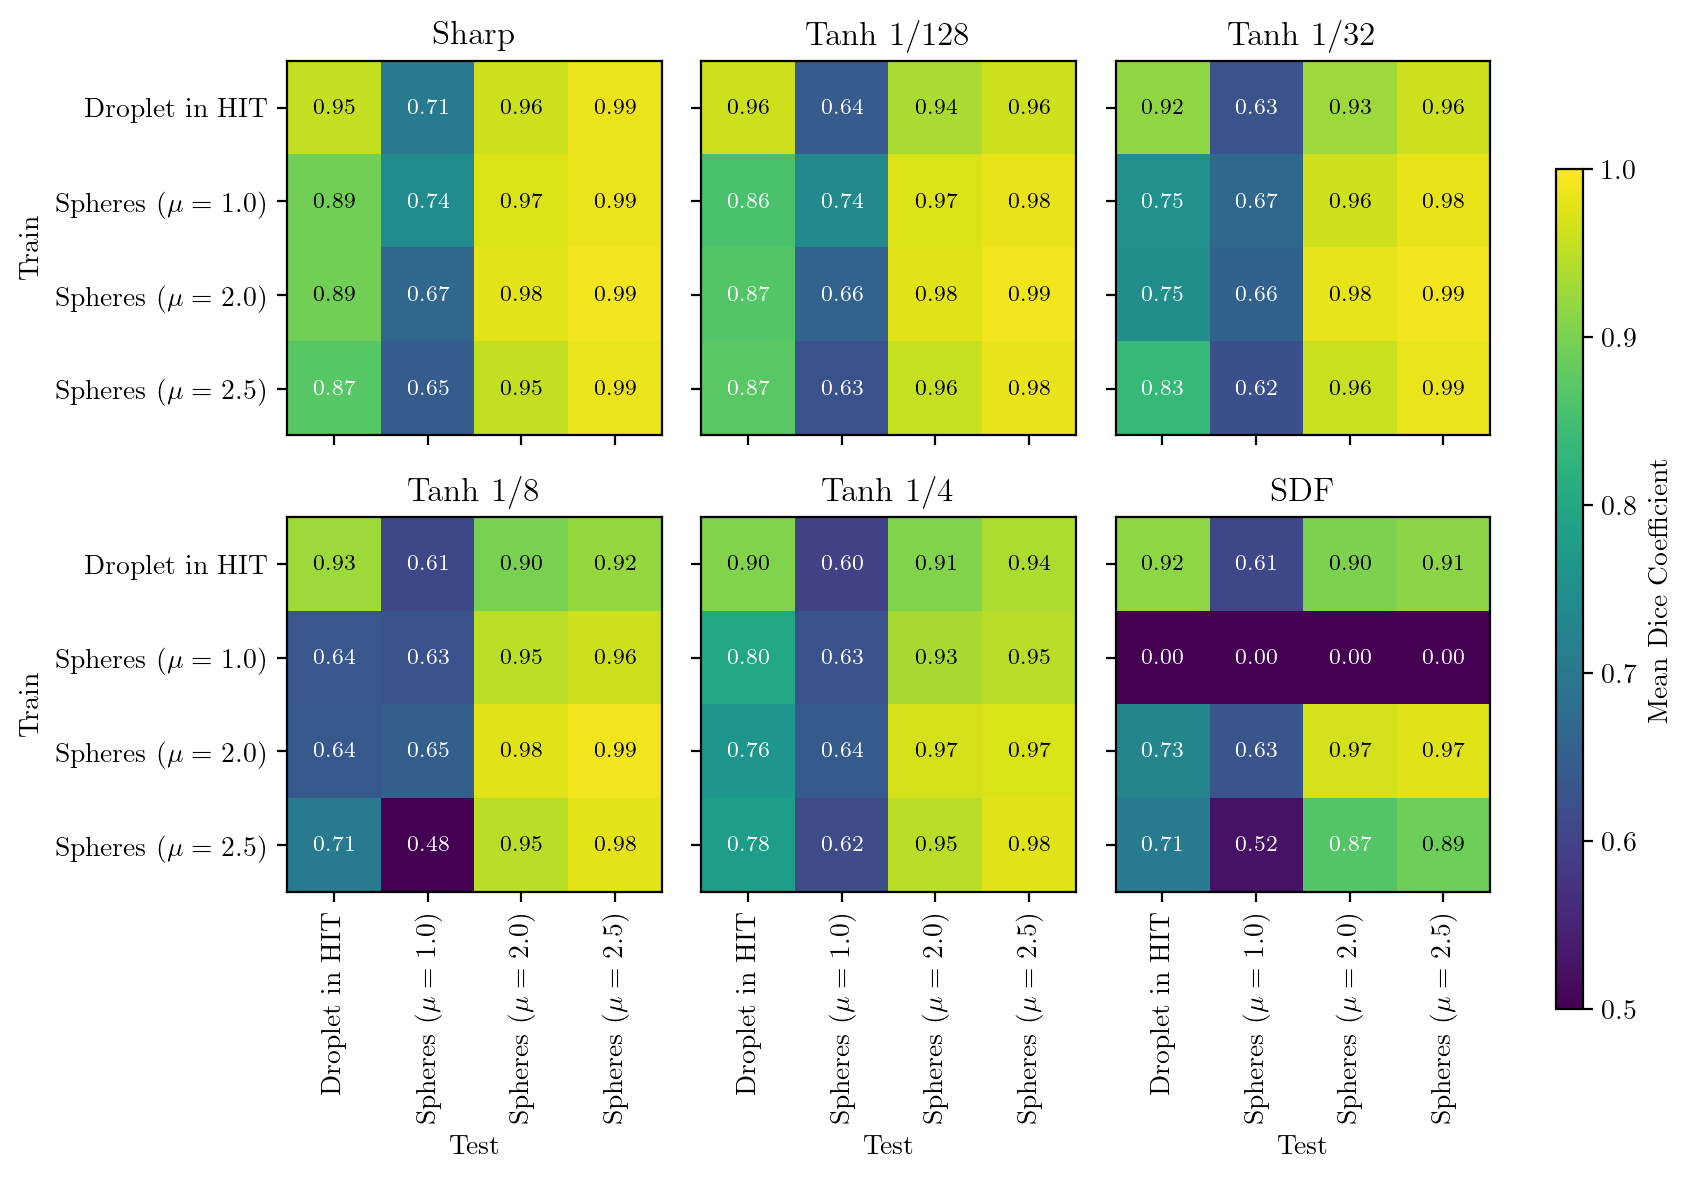

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Find indices of all 'tanh' labels
tanh_indices = [i for i, (lab, _) in enumerate(subdfs) if 'tanh' in lab.lower()]

print(tanh_indices)

# Build new subdfs: keep all non-tanh, and for tanh, keep every other
keep = set()
toggle = False
for i, (lab, _) in enumerate(subdfs):
    if 'tanh' in lab.lower():
        if not toggle:
            keep.add(i)
        toggle = not toggle
    else:
        keep.add(i)

print(keep)
keep.add(6)

subdfs_filtered = [subdfs[i] for i in sorted(keep)]

fig, axs = plt.subplots(2, 3, figsize=(9, 6), dpi=200, sharex=True, sharey=True)

for i, (interface_label, subdf) in enumerate(subdfs_filtered):
    ax = axs[i // 3, i % 3]
    ax.set_title(interface_label)
    im = ax.imshow(subdf, cmap='viridis', vmin=0.5, vmax=1)
    ax.set_xticks(range(len(subdf.columns)))
    ax.set_yticks(range(len(subdf.index)))
    ax.set_xticklabels(subdf.columns, rotation=90)
    ax.set_yticklabels(subdf.index)
    # Annotate heatmap with values
    for (row, col), val in np.ndenumerate(subdf.values):
        color = "white" if im.norm(val) < 0.75 else "black"
        ax.text(col, row, f"{val:.2f}", ha='center', va='center', color=color, fontsize=8, fontweight='bold')

axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Train')
for j in range(3):
    axs[1, j].set_xlabel('Test')

plt.subplots_adjust(right=0.85)
cbar = fig.colorbar(im, ax=axs, cax=fig.add_axes([0.87, 0.15, 0.015, 0.7]), label='Mean Dice Coefficient')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('ood_results.pdf', bbox_inches='tight')
plt.show()